# Описание проекта

Помочь маркетолагам крупного интернет-магазина проверить список гипотез для увеличения выручки.
Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

# Оглавление

1. [Шаг 1. Изучение общей информации](#step1)  
2. [Шаг 2. Приоритизация гипотез](#step2)  
3. [Шаг 3. Анализ A/B-теста](#step3)  
4. [Шаг 4. Общий вывод](#step4)  

# Шаг 1. Изучение общей информации  <a id="step1"></a>

In [1]:
# импорт библиотеки Pandas
import pandas as pd
# импорт библиотеки numpy
import numpy as np
# импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# импорт библиотеки stats
import scipy.stats as stats
# импорт библиотеки numpy
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Прочитаем файлы и посмотрим на данные в них:

In [2]:
# чтение файла hypothesis с данными
hypothesis = pd.read_csv('/datasets/hypothesis.csv',sep = ',')
# вывод таблицы с данными
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
# вывод информации о столбцах
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# уникальные значения в столбце Reach
print("Уникальные значения в столбце Reach", hypothesis['Reach'].unique())

Уникальные значения в столбце Reach [ 3  2  8  5 10  1]


In [5]:
# уникальные значения в столбце Impact
print("Уникальные значения в столбце Impact", hypothesis['Impact'].unique())

Уникальные значения в столбце Impact [10  5  3  1  2  7  9]


In [6]:
# уникальные значения в столбце Confidence
print("Уникальные значения в столбце Confidence", hypothesis['Confidence'].unique())

Уникальные значения в столбце Confidence [8 4 7 3 1 2 9]


In [7]:
# уникальные значения в столбце Efforts
print("Уникальные значения в столбце Efforts", hypothesis['Efforts'].unique())

Уникальные значения в столбце Efforts [ 6 10  3  8  1  5]


В таблице hypothesis содержится 5 столбцов и 9 гипотез:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Пропусков в таблице нет, все гипотезы имеют все параметры Reach, Impact, Confidence, Efforts, которые необходимы для оценки приоритета проверки гипотез.

Названия столбцов в верхнем регистре, необходимо привести их к нижнему регистру.

In [8]:
# функция приведения к нижнему регистру
def replace_names(data):
    list_of_columns = []
    for column in data.columns:
        column = column.lower()
        list_of_columns.append(column)
    data.columns = list_of_columns
    return data
# заменим названия столбцов в таблице visits
hypothesis = replace_names(hypothesis)
# вывод названий столбцов
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Привели столбцы hypothesis к нижнему регистру.

Рассмотрим данные во второй таблице orders:

In [9]:
# чтение файла orders с данными
orders = pd.read_csv('/datasets/orders.csv',sep = ',')
# вывод таблицы с данными
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
# вывод информации о столбцах
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
# уникальные значения в столбце group
print("Уникальные значения в столбце group", orders['group'].unique())

Уникальные значения в столбце group ['B' 'A']


Проверим таблицу orders на наличие дублей, если ли такие пользователи, которые попали в обе группы сразу, возможно в данных есть ошибка:

In [12]:
# поиск уникальных пользователей в группе А
usersGroupA = set(orders[orders['group'] == 'A']['visitorId'])
# поиск уникальных пользователей в группе В
usersGroupB = set(orders[orders['group'] == 'B']['visitorId'])
# находим уникальных пользователей в обеих группах
usersIntersection = list(usersGroupA & usersGroupB)
print("Количество пользователей, которые попали в тест А и в тест B одновременно = ", len(usersIntersection))

Количество пользователей, которые попали в тест А и в тест B одновременно =  58


Однозначно определить какие данные учитывать в какой группе мы не можем, поэтому правильнее будет избавиться от них. 

In [13]:
# уберем из orders пользователей, которые попапли в обе группы теста
orders = orders.query('visitorId not in @usersIntersection')
print("Количество пользователей, которые остались после очистки данных от дублей = ", orders.shape[0])

Количество пользователей, которые остались после очистки данных от дублей =  1016


В таблице orders 5 столбцов и 1016 строк с данными, рассмотрим значения и тип каждого столбца:

* transactionId — идентификатор заказа; Тип int64, тип подходит
* visitorId — идентификатор пользователя, совершившего заказ; Тип int64, тип подходит
* date — дата, когда был совершён заказ; Тип object, тип необходимо привести к формату datetime, чтобы была возможность работать со столбцом как с датой
* revenue — выручка заказа; Тип int64, тип подходит
* group — группа A/B-теста, в которую попал заказ; Тип object нам подходит

Пропусков в таблице нет, все записи содержат всю информацию. В столбце с группой теста только значения A и B.

Названия столбцов подходят для дальнейшей работы с ними ничего делать не будем.

In [14]:
orders['date'] = orders['date'].astype('datetime64[D]')
print('В таблице orders привели столбец date к типу',orders.date.dtypes) 

В таблице orders привели столбец date к типу datetime64[ns]


Теперь рассмотрим таблицу visitors:

In [15]:
# чтение файла orders с данными
visitors = pd.read_csv('/datasets/visitors.csv',sep = ',')
# вывод таблицы с данными
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [16]:
# вывод информации о столбцах
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [17]:
# уникальные значения в столбце group
print("Уникальные значения в столбце group", visitors['group'].unique())

Уникальные значения в столбце group ['A' 'B']


В таблице visitors 3 столбца и 62 строк с данными, рассмотрим значения и тип каждого столбца:
* date — дата; Тип object, приведем тип к datetime
* group — группа A/B-теста; Тип object подходит
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста; Тип int64 подходит.

В таблице нет пропусков и названия понятны и представлены в нужном виде.

In [18]:
# изменение типа данных в столбцах
visitors['date'] = visitors['date'].astype('datetime64[D]')
print('В таблице visitors привели столбец date к типу',visitors.date.dtypes) 

В таблице visitors привели столбец date к типу datetime64[ns]


### Вывод

Для анализа предоставлено три таблицы:

1. **hypothesis** - таблица с гипотезами, которые необходимо проверить. 

* В таблице 5 столбцов и 9 гипотез. 
* Все параметры Reach, Impact, Confidence, Efforts заполнены, имеют значения по 10-бальной шкале. 
* Привели названия столбцов к нижнему регистру.

2.  **orders** - таблица с информацией по заказам с делением на группы АБ-теста.

* В таблице 5 столбцов и 1197 строк с данными до предобработки. После удаления дублей строк стало 1016.
* Привели столбцы к нужному типу. 
* Убедились, что в столбце с группой теста только значения A и B.

3. **visitors** - таблица с информацией по количеству пользователей и группой АБ-теста.

* В таблице 3 столбца и 62 строк с данными.
* Также привели столбцы к нужному типу.
* Убедились, что в столбце с группой теста только значения A и B.

Пропусков во всех таблицах нет, переходим к следующему шагу оценки гипотез.

# Шаг 2. Приоритизация гипотез <a id="step2"></a>

### Приоритезация гипотез с помощью фреймворка ICE

Применим фреймворк ICE для приоритизации гипотез.

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач:

**Ice Score = Impact * Confidence / Efforts**

_Impact_ — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

_Confidence_ — насколько вы уверены, что это изменение повлияет на пользователей именно так;

_Efforts_ — сколько стоит протестировать эту гипотезу.

Все эти данные представлены в таблице hypothesis, воспользуемся формулой и отсортируем гипотезы по убыванию приоритета.

In [19]:
# добавление столбца ICE 
hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis.sort_values(by='ice',ascending = False).loc[:, ['hypothesis', 'ice']]

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы 8,0,7(в порядке приоритета):
* Гипотеза 8 - Запустить акцию, дающую скидку на товар в день рождения
* Гипотеза 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Гипотеза 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Приоритезация гипотез с помощью фреймворка RICE

Применим фреймворк RICE для приоритизации гипотез.
У метода ICE есть модификация RICE (R от англ. reach, «охват»):
    
**Rice Score = Reach * Impact * Confidence / Efforts**

Фреймворк RICE состоит из четырёх компонент:
    
_Reach_ — скольких пользователей затронет изменение, которое вы хотите внести;

_Impact_ — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

_Confidence_ — насколько вы уверены, что это изменение повлияет на пользователей именно так;

_Efforts_ — сколько стоит протестировать эту гипотезу.

Все эти данные представлены в таблице hypothesis, воспользуемся формулой и отсортируем гипотезы по убыванию приоритета.

In [20]:
# добавление столбца RICE 
hypothesis['rice'] = (hypothesis.impact * hypothesis.confidence * hypothesis.reach) / hypothesis.efforts

print(hypothesis.sort_values(by='rice',ascending = False).loc[:, ['hypothesis', 'rice']])

                                          hypothesis   rice
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Наиболее перспективные гипотезы 7,2(в порядке приоритета). Следом две гипотезы набрали одинаковое количество баллов - 40, гипотеза 0 и 6.

* Гипотеза 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Гипотеза 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Перспективные гипотезы посчитанные разными фреймворками ICE и RICE, получились разные 8,0,7 против 7,2. Так получилось, потому что гипотезы 7 и 2 имеют высокий показатель Reach(охват), в то время как у гипотез 8 и 0, этот показатель равень 1 и 3 соответственно.

### Выводы

В данном разделе с помощью фреймворков ICE и RICE были отобраны наиболее перспективные гипотезы:

* с помощью ICE получили 8,0,7 гипотезы
* с помощью RICE получили 7,2 гипотезы.

Изменение произошло потому, формулы фреймворков одинаковые, за исключение того, что RICE учитывает охват пользователей. Поскольку восьмая гипотеза охватит наименьший объем пользователей, а седьмая - набольший, результат получился разный.

# Шаг 3. Анализ A/B-теста <a id="step3"></a>

Команда провела A/B-тест, результаты которого представлены в таблицах orders и visitors, давайте проанализируем полученные результаты.

Построим график кумулятивной выручки по группам.

In [21]:
# создание датафрейма с уникальными парами значений 'date' и 'group', таблицы orders
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups. Затем агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму выручки:

In [22]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                   .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
                   .sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [23]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                       .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


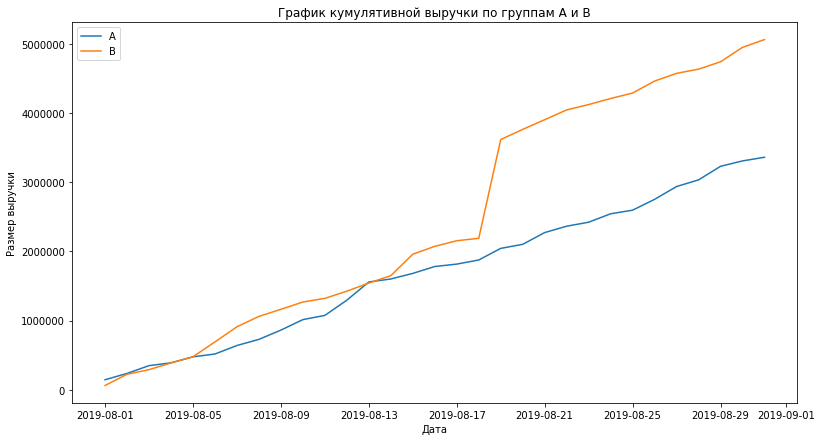

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График кумулятивной выручки по группам A и B')
# подпишем оси координат
plt.ylabel('Размер выручки')
plt.xlabel('Дата')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.show() 

Выручка почти равномерно увеличивается в течение всего теста в каждой группе. Хороший знак.
Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы необходимо проанализировать отдельно.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

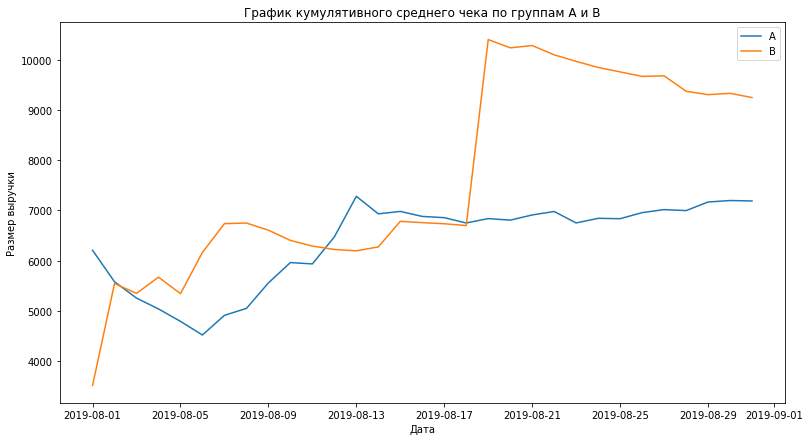

In [25]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График кумулятивного среднего чека по группам A и B')
# подпишем оси координат
plt.ylabel('Размер выручки')
plt.xlabel('Дата')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show() 

Средний чек становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B, после резкого роста в районе 19.08.2019. Возможно, в группу B середине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного различия для среднего чека. 

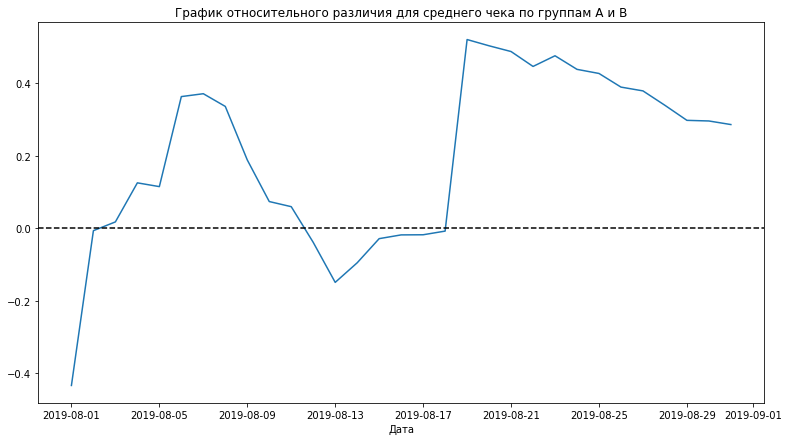

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График относительного различия для среднего чека по группам A и B')
# подпишем оси координат
plt.xlabel('Дата')

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show() 

В нескольких точках график различия в среднем чеке резко «скачет». Видимо, именно тогда были совершены аномальные заказы.

Проанализируем график кумулятивной конверсии.

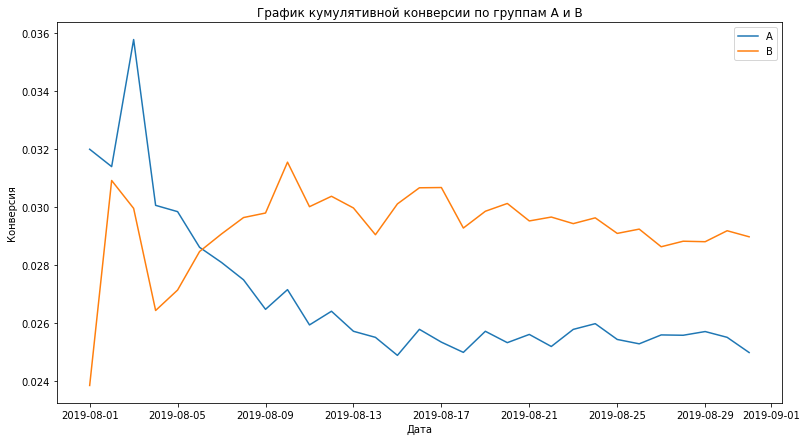

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График кумулятивной конверсии по группам A и B')
# подпишем оси координат
plt.xlabel('Дата')
plt.ylabel('Конверсия')
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.show()

В начале теста сегмент А имел бОльшую конверсию, но постепенно сегмент В вырвался вперед. Переломный момент случился где-то 7 августа 2019г, после этой даты конверсия группы В начала рости и выглядит стабильной, а конверсия группы А наоборот упала и также стабилизировалась в районе 0.025.

Построим график относительного различия кумулятивных конверсий:

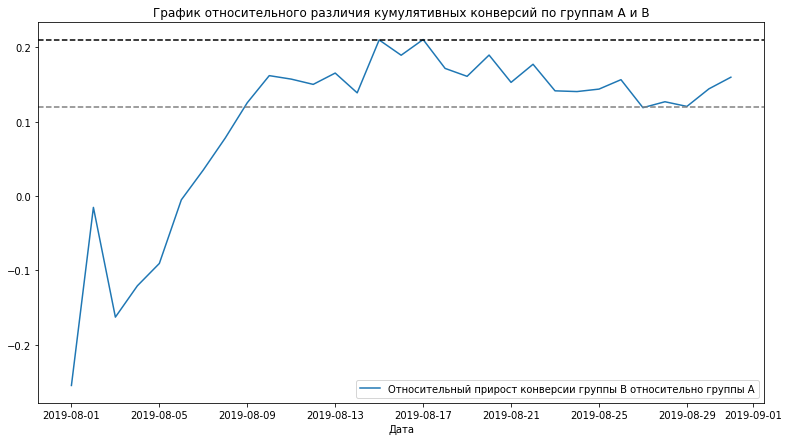

In [28]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График относительного различия кумулятивных конверсий по группам A и B')
# подпишем оси координат
plt.xlabel('Дата')

# строим графики
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0.21, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.show()

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. 
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя, выводы можно будет делать после анализа выбросов и аномалий. 

Изучим гистограмму распределения количества заказов на пользователя:

In [29]:
# создание датафрейма с количеством заказов по посетителям
ordersByUsers = (orders
                 .groupby('visitorId', as_index=False)
                 .agg({'transactionId' : pd.Series.nunique})
                )
ordersByUsers.columns = ['userId','orders']
ordersByUsers.head()

,userId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


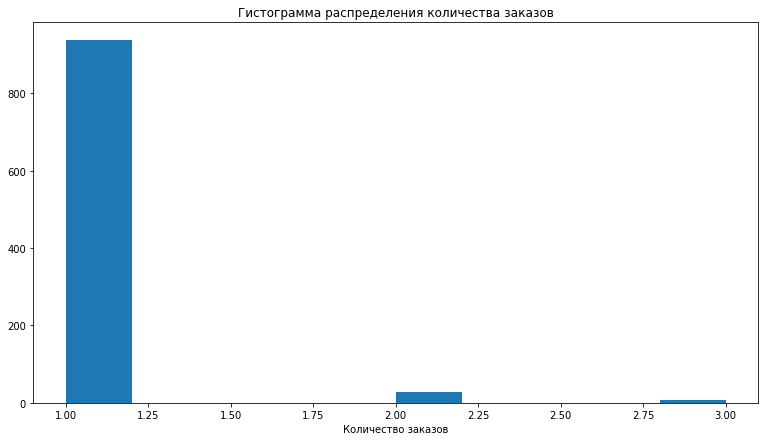

In [30]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('Гистограмма распределения количества заказов')
# подпишем оси координат
plt.xlabel('Количество заказов')
# рисуем гистограмму
plt.hist(ordersByUsers['orders']) 
plt.show()

Большинство покупателей заказывало только один раз, но есть и те кто заказывал 2-3 раза.

In [31]:
# получение информации по количеству заказов
ordersByUsers['orders'].describe()

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

Большинство пользователей совершили не более одного заказа. Максимальное число заказов составляет 3.

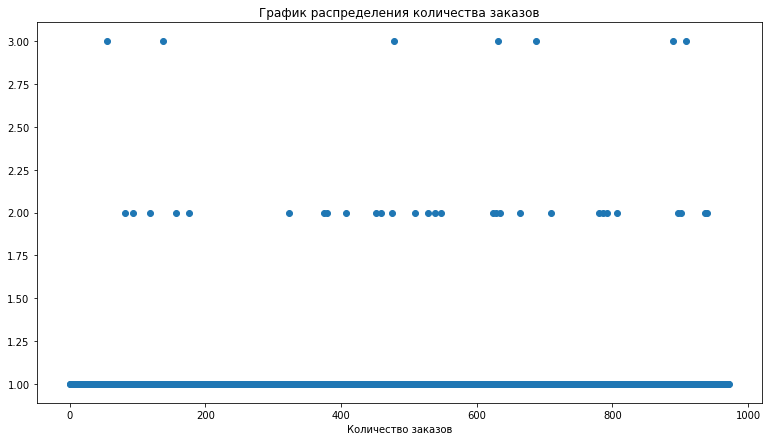

In [32]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График распределения количества заказов')
# подпишем оси координат
plt.xlabel('Количество заказов')
# рисуем гистограмму
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

Среди тех кто заказывал более одного раза больше всего пользователей с 2-3 заказами. Посчитаем перцентили, чтобы понять какое количество заказов считать аномальными.

In [33]:
# расчет перцентили 95 и 99-й
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Более одного заказа оформили не более 5% пользователей. Тех кто оформил более двух заказов - не более процента. Граница до двух заказов кажется разумной, поскольку такие пользователи все же регулярно встречаются на графике, а все что выше - аномалия.

Изучим гистограмму распределения стоимости заказов:

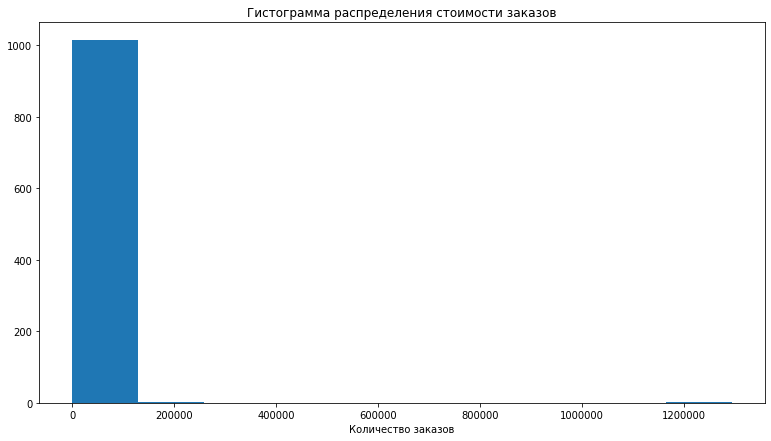

In [34]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('Гистограмма распределения стоимости заказов')
# подпишем оси координат
plt.xlabel('Количество заказов')
# рисуем гистограмму
plt.hist(orders['revenue'])
plt.show()

Есть заказы дороже 200 000, но их очень мало, посмотрим на точечный график:

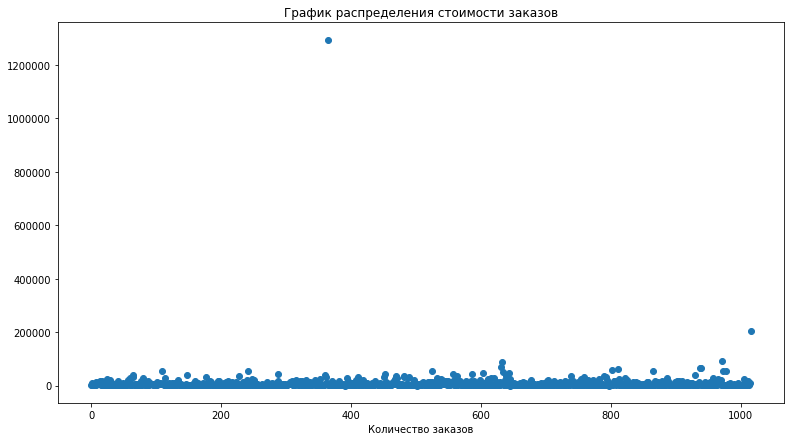

In [35]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('График распределения стоимости заказов')
# подпишем оси координат
plt.xlabel('Количество заказов')
# рисуем гистограмму
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.show()

Всего два заказа выбивается из общей массы, причем один заказ около полутора миллионов! Это похоже на аномалию, необходимо передать информацию разработчикам или тем кто собирал данные. Найдем выборочные перцентили:

In [36]:
# расчет перцентили 95 и 99-й
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов дороже 26785 и не более 1% заказов дороже 53904. Для будущих расчетов возьмем порог в 30 000.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным. 

In [37]:
# количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [38]:
# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = (visitorsADaily
                        .apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                               .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
                       )
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [39]:
# количество пользователей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBDaily.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [40]:
# количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = (visitorsBDaily
                        .apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                               .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
                       )
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [41]:
#  ordersPerDateA - количество заказов в выбранную дату в группе A
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


In [42]:
# суммарное число заказов до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


In [43]:
#  ordersPerDateB - количество заказов в выбранную дату в группе B
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [44]:
# суммарное число заказов до выбранной даты включительно в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [45]:
# объединение полученных таблиц в общий датафрейс по дате
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов:

In [46]:
# подсчет количества заказов для тех пользователей, кто сделал хоть один заказ из группы А
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [47]:
# подсчет количества заказов для тех пользователей, кто сделал хоть один заказ из группы В
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [48]:
# объединение тех пользователей, кто ничего не заказывал из группы А
sampleA = pd.concat([ordersByUsersA['orders'],\
                      pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                name='orders')],axis=0)
sampleA.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [49]:
# объединение тех пользователей, кто ничего не заказывал из группы В
sampleB = pd.concat([ordersByUsersB['orders'],\
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                               name='orders')],axis=0)
sampleB.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Посмотрим на гистограмму распределения получившихся выборок sampleA и sampleB.

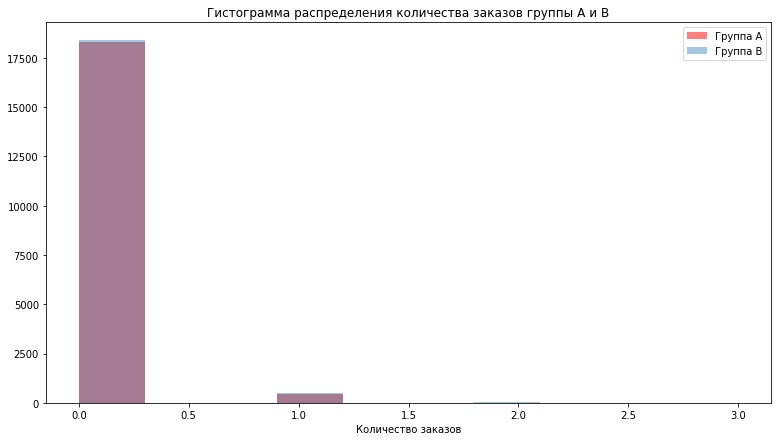

In [50]:
# размер графика
plt.figure(figsize=(13, 7))
# заголовок графика
plt.title('Гистограмма распределения количества заказов группы А и В')
# подпишем оси координат
plt.xlabel('Количество заказов')
# рисуем гистограмму
plt.hist(sampleA, alpha = 0.5, color='r', label='Группа А')
plt.hist(sampleB,alpha = 0.4, label='Группа B')
plt.legend()
plt.show()

Гистограмма выборок не похожа на нормальное распеределение, на всякий случай проверим гипотезу о нормальности с использованием критерия Шапиро-Уилка, поскольку он обладает бОльшей мощностью, чем критерий хи-квадрат.

**Гипотеза 0**: sampleA распределена по нормальному закону

**Гипотеза 1**: sampleA распределена не нормально

In [51]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.shapiro(sampleA)
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Тоже самое проделаем для sampleB:

**Гипотеза 0**: sampleB распределена по нормальному закону

**Гипотеза 1**: sampleB распределена не нормально

In [52]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.shapiro(sampleB)
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Что и требовалось доказать, обе выборки с количеством заказов распределены не нормально.

Это значит, что для проверки статистической значимости различий в конверсии между группами по «сырым» данным
будем использовать непараметрический критерий Уилкоксона-Манна-Уитни, потому что:

1) сравниваемые значения не составляют пару коррелирующих  значений

2) распределение признаков в каждой выборке не соответствует нормальному распределению

3) в данных есть выбросы и параметрические критерии могут дать неверный результат. 

Сформируем нулевую и альтернативную гипотезы. 

**Гипотеза 0:** Конверсия между группами по «сырым» данным одинакова

**Гипотеза 1:** Разница в конверсии между группами по «сырым» данным статистически значима

Зададим уровень значимости = 0.05

In [53]:
# критический уровень статистической значимости
alpha = 0.05  

results = stats.mannwhitneyu(sampleA, sampleB, True, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print("Конверсия группы В выше на {0:.1%}".format((sampleB.mean() / sampleA.mean() - 1)))    

p-значение:  0.011018084110014691
Отвергаем нулевую гипотезу: разница статистически значима
Конверсия группы В выше на 16.0%


P-value меньше, чем 0.05. Значит, на сырых данных гипотезу об отсутствии статистически значимых различий в конверсии нужно отвергнуть: конверсия отличается. Второе число показывает, насколько: конверсия группы В на сырых данных статистически выше на 16.0%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным, для этого сформируем гипотезы:

**Гипотеза 0**: Средний чек в обеих группах по «сырым» данным одинаков

**Гипотеза 1**: Разница в среднем чеке заказа между группами по «сырым» данным статистически значима

Также как и выше зададим уровень значимости = 0.05 и воспользуемся критерием Уилкоксона-Манна-Уитни.

In [54]:
# критический уровень статистической значимости
alpha = 0.05  

results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], True, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print("Средний чек группы В выше на {0:.1%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))  

p-значение:  0.8294908998149533
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Средний чек группы В выше на 28.7%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы B значительно выше среднего чека группы A, более чем на 28%.

Теперь посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Уберем из выборок аномалии. Напомню, что аномальными пользователями считаем тех, кто совершил от 3 заказов или совершил заказ от 30 000 р. Так уберем от 1 до 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

In [55]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
dtype: int64
(42,)


Всего 42 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [56]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Cформулируем гипотезы и также как и выше применим критерий Уилкоксона-Манна-Уитни с уровнем значимости 0.05.

**Гипотеза 0**: Конверсия между группами по «очищенным» данным одинакова

**Гипотеза 1**: Разница в конверсии между группами по «очищенным» данным статистически значима

In [57]:
# критический уровень статистической значимости
alpha = 0.05  

results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print("Конверсия группы В выше на {0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


p-значение:  0.013307421246884773
Отвергаем нулевую гипотезу: разница статистически значима
Конверсия группы В выше на 16.1%


Результаты по конверсии практически не изменились. P-value по-прежнему меньше, чем 0.05, конверсия группы В над группой А по-прежнему лучше. Таким образом, на конверсию аномалии почти не повлияли.

Посчитайем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным с помощью критерия Уилкоксона-Манна-Уитни.

**Гипотеза 0**: Средний чек в обеих группах по «очищенным» данным одинаков

**Гипотеза 1**: Разница в среднем чеке заказа между группами по «очищенным» данным статистически значима

In [58]:
# критический уровень статистической значимости
alpha = 0.05  

results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
    True, alternative = 'two-sided'
        )


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print("Средний чек группы В выше на {0:.1%}".format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1)) 

p-значение:  0.8422581360962005
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Средний чек группы В выше на -3.1%


P-value сохранился на уровне значительно выше 0.05. Следовательно, нельзя отвергнуть гипотезу, что в средних чеках групп А и В нет различий. Без учета аномалий средний чек группы В сократился с 28%(средний чек на сырых данных) до 3%.

### Вывод

В ходе проведенного анализа в Шаге 2 получили следующие результаты:

1. Проанализировав данные обнаружили аномальные данные. 
    * Большинство покупателей заказывало только один раз, но есть и те кто заказывал более 2х раз.
    * Не более 5% заказов дороже 26 000 и не более 1% заказов дороже 53 000. 
4. На сырых данных графики кумулятивного среднего чека по группам и относительного изменения среднего чека группы В к группе А нестабильны вплоть до последних дней теста. 
3. Конверсия группы В над группой А лучше, такие результаты получили как по «сырым» данным так и по «очищенным».
3. «Сырые» данные практически не повлияли на поведение метрик, кроме среднего чека. Средний чек группы В к концу теста оказался несущественно выше среднего чека группы А.

# Шаг 4. Общий вывод <a id="step4"></a>

На основе результатов, полученных в ходе анализа:
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Есть статистически значимое различие по среднему чеку между группами как по сырым данным, так и после удаления аномалий.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту.
- График различия среднего чека колеблется, он то растет, то падает. Сделать из этого графика определённые выводы нельзя.

Завершаем тест. Продолжать тест смысла нет: группа B статистически значимо лучше группы A по обеим метрикам.